In [2]:
import numpy as np
from scipy.stats import spearmanr
from scipy import sparse
import cmath
from sklearn.decomposition import PCA
import sys, os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.pyplot import cm



sys.path.append('/mnt/e/dhh-soltesz-lab/zfish-proj/src-parallel/operation-figgeritout/comp-modeling/utils')
from futils import read_metrics_filepath, extract_weights, data2percentile, get_hilbert, get_phases, get_synch, jthreshold
from modeling_analysis_utils import extract_top_J, load_simulation_parameters, load_baier_connectome
from rnn_modeling_utils import solve_stochastic_euler

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

matplotlib.rc('font', **font)

%load_ext autoreload
%autoreload 2

In [3]:
FISH_ID = 2
version = 1
def acquire_info(date, state, idx):
    J_filepath           = '/mnt/f/dhh-soltesz-lab/zfish-modeling-outputs/f%i/%s/v%i/training-%s' % (FISH_ID, state, version, date)
    parameters_filepath  = '/mnt/f/dhh-soltesz-lab/zfish-modeling-outputs/f%i/%s/v%i/additional-info-%s.npz' % (FISH_ID, state, version, date)

    f = np.load(J_filepath + '/full-%s-%i.npz' % (state,idx), allow_pickle=True)
    J = f['J']
    N = J.shape[0]
    f.close()

    simulation_kwargs = load_simulation_parameters(parameters_filepath)
    simulation_kwargs['J'] = J

    Ytruth = simulation_kwargs['Ytruth']
    currents    = solve_stochastic_euler(**simulation_kwargs)
    activations = np.tanh(currents)
    Ymodel      = np.matmul(J, activations)


    simulation_kwargs['H'] = np.zeros_like(simulation_kwargs['H'], dtype='float32')
    currents_naked    = solve_stochastic_euler(**simulation_kwargs)
    activations_naked = np.tanh(currents_naked)
    Ymodel_naked     = np.matmul(J, activations_naked)
    
    return {'S': simulation_kwargs['S'], 'spatial': simulation_kwargs['spatial'], 'J': J, 'Ytruth': Ytruth, 'Ymodel': Ymodel, 'Ymodel naked': Ymodel_naked, 'currents': currents, 'currents naked': currents_naked}
# 2 381 270
# 3 646 285
# 5 362 83
baseline_data = acquire_info('3152020', 'baseline', 381)
presz_data    = acquire_info('3152020', 'presz', 270)

Jbaseline = baseline_data['J']
Jpresz    = presz_data['J']

In [71]:
# controlability

def controlability(A):
    from scipy.sparse.linalg import svds
    from scipy.linalg import schur
    import numpy.matlib
    
    _, s, _ = svds(A,1)
    A = A / (1. + s)
    T, U = schur(A, 'real')
    midMat = (U ** 2).T
    v = np.diag(T).reshape(-1,1)
    P = np.diag(1. - np.matmul(v,v.T))
    P = np.tile(P, (A.shape[0],1))
    return np.sum((midMat/P).T, axis=0)

connectome = load_baier_connectome()
min_nonzero  = np.min(connectome[connectome > 0])
connectome = np.log10(connectome + min_nonzero)
maxS, minS = np.max(connectome), np.min(connectome)
connectome  = ((connectome - minS) / (maxS - minS))
connectome += min_nonzero

control = controlability(connectome)

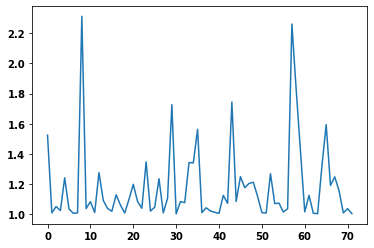

In [72]:
plt.figure()
plt.plot(control)
plt.show()

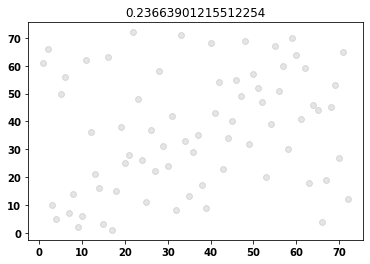

(72, 72)
0.875 0.8888888888888888
0.25 0.6388888888888888


In [93]:
from scipy.stats import rankdata

#thalamus_idxs = [1905,1906,1914,1944,1945,1946,1947,1948,1949,1950,1953,1954,1968,1971,1982,2032,2035,2038,2039,2040,2041,2045,2048,2056,2064,2065,2069,2070,2144,2186,2187,2188,2189,2190,2191,2193,2195,2200,2201,2205,2215,2251,2252,2257,2262,2267,2293,2300,2303,3894,3943,3944,3952,4063,4066,4068,4072,4074,4075,4077,4078,4079,4080,4081,4084,4086,4090,4092,4098,4099,4100,4104,4106,4107,4108,4109,4110,4111,4113,4117,4118,4125,4127,4131,4133,4134,4135,4141,4144,4147,4148,4156,4163,4164,4171,4172,4178,4180,4181,4182,4183,4184,4185,4187,4188]

degree_ranked = rankdata(connectome.sum(axis=0))
control_ranked = rankdata(control)

plt.figure()
plt.scatter(degree_ranked, control_ranked, color='k', alpha=0.10)
#plt.scatter(degree_ranked[thalamus_idxs], control[thalamus_idxs], color='r', alpha=0.5)

plt.title(np.corrcoef(degree_ranked, control_ranked)[0,1])
plt.show()

# olfactory 32, 33 surprisingly high control for low rank
# thalamus 60, 61
# habenula 8,9
a1, a2 = 60, 61
print(connectome.shape)
print(degree_ranked[a1]/float(len(degree_ranked)), degree_ranked[a2]/float(len(degree_ranked))) # l/r thalamus?
print(control_ranked[a1]/float(len(control_ranked)), control_ranked[a2]/float(len(control_ranked)))


In [3]:
from futils import pca_analysis

baseline_pca, baseline_transformed = pca_analysis(baseline_traces, kernel='linear')
_, presz_transformed = pca_analysis(presz_traces, kernel='linear', pca=baseline_pca)

NameError: name 'baseline_traces' is not defined

In [77]:
## from eff con modeling

fish_id = 2
metrics_filepath = '/mnt/f/dhh-soltesz-lab/zfish-fc/f%i-perturbation/baseline/graph-metrics' % fish_id

# Baseline
baseline_thalamus_idxs = [1905,1944,1945,1946,1947,1948,1949,1950,1952,1971,1972,1982,2030,2035,2038,2040,2041,2045,2047,2048,2051,2057,2063,2064,2065,2069,2091,2093,2096,2098,2102,2118,2120,2129,2134,2137,2139,2141,2144,2148,2152,2158,2159,2167,2169,2170,2172,2178,2181,2184,2186,2187,2188,2189,2190,2191,2193,2195,2198,2217,2226,2227,2238,2242,2243,2244,2247,2248,2250,2251,2252,2253,2256,2262,2275,2276,2277,2283,2285,2288,2289,2293,2294,2296,2297,2303,4066,4068,4076,4077,4078,4080,4091,4093,4094,4104,4106,4108,4123,4131,4135,4147,4148,4153,4163,4166,4171,4179,4182,4184,4186,4187]
baseline_tectum_idxs = [14,16,17,19,21,40,41,45,58,60,94,107,116,145,149,164,171,280,305,363,429,460,475,504,509,511,579,625,642,657,703,793,796,799,874,875,1022,1117,1169,1170,1171,1182,1193,1220,1221,1267,1282,1317,1330,1920,1928,1984,2312,2366,2398,2407,2881,2882,2887,2889,2901,2903,2911,2922,2924,2932,2934,2937,2939,2949,2959,2971,2972,2978,2983,2985,2987,2994,3000,3008,3028,3039,3058,3071,3072,3075,3077,3079,3090,3120,3125,3139,3161,3162,3164,3174,3175,3176,3177,3178,3180,3184,3203,3204,3207,3208,3209,3211,3214,3215,3222,3224,3235,3238,3247,3248,3250,3251,3253,3255,3257,3261,3266,3267,3268,3274,3280,3290,3291,3296,3297,3298,3308,3321,3322,3345,3348,3349,3351,3352,3353,3357,3379,3381,3402,3404,3408,3413,3425,3430,3432,3442,3450,3455,3456,3457,3459,3460,3462,3465,3468,3475,3483,3502,3509,3515,3528,3531,3535,3536,3539,3541,3542,3543,3550,3556,3564,3565,3568,3569,3579,3581,3583,3586,3587,3590,3592,3593,3625,3637,3640,3643,3645,3649,3652,3653,3656,3663,3668,3671,3672,3676,3677,3679,3684,3685,3686,3688,3695,3698,3701,3710,3711,3715,3718,3721,3724,3725,3729,3731,3732,3736,3737,3738,3745,3746,3747,3750,3760,3761,3764,3765,3767,3770,3771,3772,3773,3779,3781,3783,3785,3787,3792,3798,3801,3808,3813,3817,3820,3823,3825,3826,3827,3832,3833,3837,3844,3858,3864,3865,3866,3941,3945,4194,4219,4240,4284,4315,4324,4341,4351,4356,4361,4469,4481,4509,4531]
baseline_telen_idxs = [545,549,550,552,560,1342,1349,1356,1363,1372,1374,1383,1384,1385,1386,1389,1397,1410,1415,1419,1425,1427,1432,1436,1507,1508,1510,1514,1516,1521,1530,1535,1536,1543,1545,1549,1553,1555,1560,1564,1566,1567,1568,1575,1576,1585,1586,1593,1595,1600,1602,1615,1620,1621,1623,1624,1626,1627,1631,1632,1633,1638,1643,1644,1652,1656,1658,1661,1663,1665,1666,1668,1670,1671,1672,1674,1675,1676,1677,1678,1680,1681,1682,1686,1714,1719,1722,1725,1730,1732,1735,1736,1738,1741,1746,1747,1748,1749,1752,1758,1766,1781,1784,1798,1806,1811,1827,1835,1838,1842,1844,1852,1859,1861,1867,1871,1875,1876,1877,1878,1879,1887,2028,2112,2173,2220,2286,2295,2309,2315,2354,2537,2538,2539,2564,2567,2571,2575,2584,2600,2602,2611,2618,2632,2633,2643,2646,2658,2667,2674,2685,2688,2691,2705,2717,2727,2728,2745,2763,2782,2785,2800,2802,2807,2808,2809,2813,2821,2822,2829,2834,2840,2848,2852,2855,2872,2879,3158,4067,4105,4138]
baseline_evc_idxs  = [226,229,233,261,262,272,281,297,298,329,350,354,376,378,524,577,582,583,584,585,587,588,589,593,594,597,599,602,603,604,618,619,627,631,648,649,654,664,670,672,673,675,679,681,687,690,691,695,696,697,699,700,702,704,706,710,711,712,717,718,719,720,723,724,726,730,734,737,743,744,745,746,747,751,752,753,756,757,759,763,766,767,768,769,772,775,776,778,779,780,781,782,783,785,787,788,789,790,791,801,802,808,811,812,813,815,824,829,830,831,832,836,837,839,841,846,848,856,857,858,861,869,872,880,883,890,895,896,899,903,909,911,917,918,919,923,924,928,934,937,938,939,940,941,944,948,952,954,955,962,964,968,971,974,978,979,981,982,983,984,985,986,987,989,992,994,995,998,1000,1004,1006,1008,1009,1010,1013,1014,1015,1017,1028,1029,1030,1031,1033,1034,1035,1037,1041,1042,1044,1050,1051,1052,1058,1059,1065,1066,1069,1072,1074,1075,1076,1078,1081,1083,1086,1088,1091,1097,1099,1108,1111,1112,1115,1132,1210,1219,1270,1303,1903,1905,1924,1939,1940,1943,1944,1946,1947,1949,1950,1952,1953,1964,1965,1971,1972,1982,1992,1993,2000,2003,2007,2016,2017,2018,2030,2035,2038,2040,2041,2045,2047,2048,2051,2057,2058,2063,2065,2069,2087,2091,2093,2096,2098,2102,2107,2109,2115,2118,2120,2131,2134,2137,2139,2141,2148,2152,2153,2167,2169,2178,2181,2184,2186,2187,2188,2189,2190,2191,2193,2195,2198,2217,2226,2227,2236,2238,2242,2243,2244,2248,2250,2251,2252,2253,2262,2267,2275,2276,2277,2283,2285,2288,2289,2293,2294,2296,2304,2438,2439,2440,2442,2443,2446,2479,2490,2497,2509,3867,3868,3869,3873,3874,3878,3879,3880,3888,3889,3890,3891,3892,3903,3904,3906,3910,3918,3924,3930,3944,3951,3952,3958,3961,3966,3987,3988,3989,3990,3991,3992,3994,4000,4004,4008,4011,4012,4014,4015,4017,4018,4020,4023,4027,4032,4038,4039,4040,4042,4044,4046,4047,4050,4052,4053,4059,4066,4068,4076,4077,4078,4080,4086,4091,4093,4094,4099,4104,4106,4108,4122,4131,4135,4147,4148,4153,4156,4161,4163,4166,4171,4179,4181,4182,4185,4186,4197,4199,4200,4203,4224,4233,4288,4302,4312,4314,4316,4330,4331,4333,4335,4340,4342,4347,4349,4352,4362,4375,4381,4386,4387,4388,4395,4396,4398,4403,4409,4433,4441,4460,4466,4468,4477,4505,4517,4519,4529,4536,4545,4547,4548]


presz_thalamus_idxs = [1905,1906,1914,1944,1945,1946,1947,1948,1949,1950,1953,1954,1968,1971,1982,2032,2035,2038,2039,2040,2041,2045,2048,2056,2064,2065,2069,2070,2144,2186,2187,2188,2189,2190,2191,2193,2195,2200,2201,2205,2215,2251,2252,2257,2262,2267,2293,2300,2303,3894,3943,3944,3952,4063,4066,4068,4072,4074,4075,4077,4078,4079,4080,4081,4084,4086,4090,4092,4098,4099,4100,4104,4106,4107,4108,4109,4110,4111,4113,4117,4118,4125,4127,4131,4133,4134,4135,4141,4144,4147,4148,4156,4163,4164,4171,4172,4178,4180,4181,4182,4183,4184,4185,4187,4188]
presz_telen_idxs    = [545,547,550,552,557,560,563,1342,1363,1364,1368,1372,1374,1376,1377,1380,1384,1385,1386,1389,1391,1397,1410,1415,1426,1427,1431,1436,1437,1439,1440,1448,1504,1518,1521,1528,1530,1533,1559,1561,1562,1563,1564,1574,1582,1585,1586,1590,1593,1594,1600,1602,1605,1606,1609,1615,1621,1623,1626,1627,1644,1649,1650,1654,1669,1674,1675,1676,1684,1685,1688,1714,1717,1718,1719,1720,1725,1740,1742,1744,1746,1748,1749,1760,1766,1769,1781,1782,1784,1798,1800,1806,1819,1821,1827,1828,1831,1838,1859,1867,1871,1877,1879,2089,2091,2093,2094,2096,2098,2113,2114,2115,2116,2118,2120,2132,2134,2138,2140,2142,2177,2178,2184,2227,2230,2232,2234,2236,2239,2247,2255,2256,2259,2260,2264,2265,2266,2269,2270,2281,2284,2346,2354,2371,2458,2460,2466,2484,2489,2523,2530,2538,2543,2546,2593,2600,2602,2603,2611,2617,2621,2626,2632,2639,2643,2658,2667,2676,2683,2685,2688,2691,2717,2725,2728,2767,2770,2785,2802,2809,2822,2834,2848,2861,2879,4093,4155]
presz_tectum_idxs   = [17,19,27,28,40,45,48,57,59,76,88,89,94,119,120,124,129,132,139,149,154,167,168,170,171,188,189,234,241,246,264,269,275,276,283,289,305,324,332,335,337,339,360,364,368,394,420,424,428,439,443,448,459,461,475,482,491,494,504,505,508,509,512,513,519,523,593,596,660,669,796,857,931,938,942,945,946,957,958,1020,1067,1076,1126,1143,1163,1185,1191,1193,1223,1229,1263,1264,1282,1309,1317,1330,1899,1998,2004,2317,2375,2391,2412,2452,2505,2888,2890,2903,2926,2938,2939,2949,2960,2961,2975,2976,2982,2983,2987,2992,3040,3056,3075,3077,3086,3093,3104,3108,3116,3125,3126,3161,3162,3171,3177,3181,3183,3184,3190,3197,3200,3203,3204,3207,3208,3210,3211,3212,3214,3218,3223,3224,3226,3234,3238,3239,3245,3247,3250,3253,3255,3267,3268,3274,3280,3284,3291,3321,3348,3349,3355,3357,3359,3378,3387,3391,3393,3401,3404,3411,3420,3428,3436,3437,3438,3455,3457,3461,3468,3483,3509,3533,3537,3556,3557,3560,3563,3564,3565,3569,3586,3589,3590,3592,3595,3604,3625,3627,3629,3632,3637,3638,3639,3640,3645,3649,3653,3665,3666,3671,3676,3677,3680,3681,3684,3685,3686,3690,3691,3692,3694,3707,3711,3718,3724,3725,3729,3732,3736,3738,3751,3755,3758,3760,3767,3771,3777,3779,3792,3808,3817,3818,3820,3838,3843,3844,3849,3865,3979,4228,4255,4259,4289,4292,4332,4338,4356,4369,4478,4482,4505,4509]


In [29]:
## Extract graph metrics



nmatrices=360
dynamic_degree_centrality, dynamic_eigenvector_centrality, dynamic_clustering_coefficient = read_metrics_filepath(metrics_filepath, nmatrices, verbose=True)
dynamic_degree_centrality_percentile, dynamic_eigenvector_centrality_percentile, dynamic_cc_percentile  = [], [], []
method = 'max'

for i in range(len(dynamic_degree_centrality)):
    dynamic_degree_centrality_percentile.append(data2percentile(dynamic_degree_centrality[i], method=method))
    dynamic_eigenvector_centrality_percentile.append(data2percentile(dynamic_eigenvector_centrality[i], method=method))
    dynamic_cc_percentile.append(data2percentile(dynamic_clustering_coefficient[i], method=method))
dynamic_degree_centrality_percentile      = np.asarray(dynamic_degree_centrality_percentile, dtype='float32')
dynamic_eigenvector_centrality_percentile = np.asarray(dynamic_eigenvector_centrality_percentile, dtype='float32')
dynamic_cc_percentile = np.asarray(dynamic_cc_percentile, dtype='float32')

dynamic_ev_deg_correlation = []
for i in range(len(dynamic_degree_centrality_percentile)):
    deg = dynamic_degree_centrality_percentile[i]
    ev  = dynamic_eigenvector_centrality_percentile[i]
    
    rho, _ = spearmanr(deg, ev)
    dynamic_ev_deg_correlation.append(rho)
    


0
100
200
300


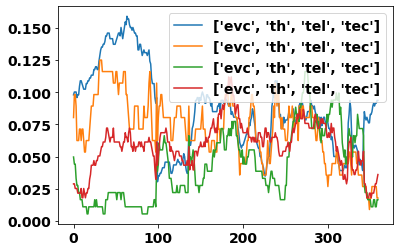

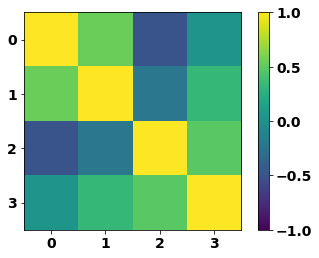

In [93]:
# are identifed ids superhubs?

def factive(raster, idxs):
    factive = []
    for t in range(raster.shape[0]):
        sl = raster[t,:]
        isactive= np.where(sl == 1)[0]
        idxs_active = list(set(isactive) & set(idxs))
        factive.append(len(idxs_active)/float(len(idxs))) 
    return factive

def extract_superhub_percentiles(idxs, spatial_cutoff=0.90):
    
    raster = []
    for i in range(len(dynamic_degree_centrality_percentile)):
        d, e = dynamic_degree_centrality_percentile[i], dynamic_eigenvector_centrality_percentile[i]
        locs = np.where( (d > spatial_cutoff) & (e > spatial_cutoff))[0]
        raster_slice = np.zeros(len(d), dtype='uint8')
        raster_slice[locs] = 1
        raster.append(raster_slice)   
    raster = np.asarray(raster, dtype='uint8')
    raster_mean = np.mean(raster, axis=0)   # T x N
    
    factives = []
    for idx in idxs:
        factives.append(factive(raster,idx))
    factives = np.asarray(factives, dtype='float32')
    plt.figure()
    plt.plot(factives.T, label=['evc', 'th', 'tel', 'tec'])
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.imshow(np.corrcoef(factives), vmin=-1., vmax=1.)
    plt.colorbar()
    plt.show()
                
#     raster_mean_percentile = data2percentile(raster_mean, method='average')
    
#     idx_percentiles = []
#     for idx in idxs:
#         idx_percentiles.append(raster_mean_percentile[idx])
    
#     plt.figure(figsize=(12,8))
#     plt.figure()
#     plt.boxplot(idx_percentiles, positions=range(len(idxs)))
#     plt.show()
    
#     plt.figure()
#     plt.plot(np.sort(idx_percentiles[0]))
#     plt.hlines(0.5, 0, len(idx_percentiles[0]), color='r', linestyle='--')
#     plt.show()

superhub_percentiles = extract_superhub_percentiles([baseline_evc_idxs, baseline_thalamus_idxs, baseline_telen_idxs, baseline_tectum_idxs])

